In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [4]:
tickers = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
start_date = "1981-01-01"
end_date = "2023-12-31"
price_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)[['Open','Close']]
price_data

[*********************100%***********************]  7 of 7 completed


Price                            Open                                     \
Ticker                           AAPL        AMZN       GOOG        META   
Date                                                                       
1981-01-02 00:00:00+00:00    0.118602         NaN        NaN         NaN   
1981-01-05 00:00:00+00:00    0.116453         NaN        NaN         NaN   
1981-01-06 00:00:00+00:00    0.111296         NaN        NaN         NaN   
1981-01-07 00:00:00+00:00    0.106570         NaN        NaN         NaN   
1981-01-08 00:00:00+00:00    0.104421         NaN        NaN         NaN   
...                               ...         ...        ...         ...   
2023-12-22 00:00:00+00:00  194.228473  153.770004  141.78181  354.512560   
2023-12-26 00:00:00+00:00  192.666124  153.559998  142.62972  353.924355   
2023-12-27 00:00:00+00:00  191.551588  153.559998  142.48010  355.001133   
2023-12-28 00:00:00+00:00  193.193528  153.720001  141.50251  358.620216   
2023-12-29 00:00:00+00:00  192.954701  153.100006  140.33536  357.912391   

Price                                                              Close  \
Ticker                           MSFT       NVDA        TSLA        AAPL   
Date                                                                       
1981-01-02 00:00:00+00:00         NaN        NaN         NaN    0.118602   
1981-01-05 00:00:00+00:00         NaN        NaN         NaN    0.116024   
1981-01-06 00:00:00+00:00         NaN        NaN         NaN    0.110867   
1981-01-07 00:00:00+00:00         NaN        NaN         NaN    0.106140   
1981-01-08 00:00:00+00:00         NaN        NaN         NaN    0.103992   
...                               ...        ...         ...         ...   
2023-12-22 00:00:00+00:00  371.648813  49.184446  256.760010  192.656189   
2023-12-26 00:00:00+00:00  372.961653  48.957491  254.490005  192.108856   
2023-12-27 00:00:00+00:00  371.658773  49.500377  258.350006  192.208359   
2023-12-28 00:00:00+00:00  373.329619  49.632352  263.660004  192.636261   
2023-12-29 00:00:00+00:00  373.956181  49.802313  255.100006  191.591385   

Price                                                                      \
Ticker                           AMZN        GOOG        META        MSFT   
Date                                                                        
1981-01-02 00:00:00+00:00         NaN         NaN         NaN         NaN   
1981-01-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
1981-01-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
1981-01-07 00:00:00+00:00         NaN         NaN         NaN         NaN   
1981-01-08 00:00:00+00:00         NaN         NaN         NaN         NaN   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  153.419998  142.370361  352.329163  372.543915   
2023-12-26 00:00:00+00:00  153.410004  142.470123  353.764832  372.623505   
2023-12-27 00:00:00+00:00  153.339996  141.093506  356.755829  372.036713   
2023-12-28 00:00:00+00:00  153.380005  140.933899  357.244354  373.240112   
2023-12-29 00:00:00+00:00  151.940002  140.584747  352.897491  373.995972   

Price                                             
Ticker                          NVDA        TSLA  
Date                                              
1981-01-02 00:00:00+00:00        NaN         NaN  
1981-01-05 00:00:00+00:00        NaN         NaN  
1981-01-06 00:00:00+00:00        NaN         NaN  
1981-01-07 00:00:00+00:00        NaN         NaN  
1981-01-08 00:00:00+00:00        NaN         NaN  
...                              ...         ...  
2023-12-22 00:00:00+00:00  48.819527  252.539993  
2023-12-26 00:00:00+00:00  49.268425  256.609985  
2023-12-27 00:00:00+00:00  49.406395  261.440002  
2023-12-28 00:00:00+00:00  49.511375  253.179993  
2023-12-29 00:00:00+00:00  49.511375  248.479996  

[10840 rows x 14 columns]

In [5]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    #when the window is out of context or no price availablee return NaN
    rs = gain / loss
    rs = rs.replace([np.inf, -np.inf], np.nan)   
    rsi = 100 - (100 / (1 + rs))
    rsi = rsi.where(~data.isna(), np.nan)
    return rsi

 
rsi= price_data['Close'].apply(lambda x: calculate_rsi(x) )
buy_signals = price_data['Close'].apply(lambda x: (calculate_rsi(x) < 25)).shift(1).fillna(False)#offset by 1 day, as the trade is executed the next day
sell_signals = price_data['Close'].apply(lambda x: (calculate_rsi(x) > 75)).shift(1).fillna(False)



In [6]:
#constants
initial_capital = 1000_000  #initial portfolio capital
commission = 0.001  #commission per trade
slippage = 0.0002  #slippage per trade
min_shares = 10  #min shares per transaction
risk_free_rate = 0.02  #annual risk-free rate
trading_days = 252  #trading days per year
max_stock_weight = 0.30 #% of total portfolio of a single stock cannot exceed 30%

In [7]:
# back test
cash = initial_capital
portfolio = {ticker: 0 for ticker in tickers}  #track the number of shares for each stock
daily_value = {ticker: [] for ticker in tickers}  #  individual stock values, starting at 0
daily_value['Portfolio'] = []  #  total portfolio value for each day
daily_value['Cash'] = []
daily_value['Action on'] = [] #record action done each day
portfolio_value = initial_capital
prev_portfolio_value = initial_capital


for date in price_data.index[1:]:
    available_stocks = price_data.loc[date, 'Close'].dropna().index.tolist()
    buy_stocks = [ticker for ticker in available_stocks if buy_signals.at[date, ticker] ] 
    n_stocks = max(len(buy_stocks),1)
    action = []
    portfolio_value=0


    for ticker in tickers:
        if ticker in available_stocks:
            open_price = price_data.at[date, ('Open', ticker)]
            close_price = price_data.at[date, ('Close', ticker)]
            equal_weight_cash = min(cash / n_stocks, max_stock_weight * prev_portfolio_value-portfolio[ticker]*open_price)#euqal weight distribution of stocks to buy


            #Buy
            if buy_signals.at[date, ticker] and cash > open_price * min_shares:
                shares_to_buy = min(cash // (open_price * (1 + commission + slippage)), equal_weight_cash // open_price)
                if shares_to_buy <0:  #rebalance if prevously exceed max weight of portfolio
                    shares_to_sell = abs(shares_to_buy)
                    revenue = shares_to_sell * open_price * (1 - commission - slippage)
                    cash += revenue
                    portfolio[ticker] -= shares_to_sell
                    action.append("rebalance sell: " + str(ticker)+str(shares_to_sell))
                else:    
                    shares_to_buy = max(min_shares, shares_to_buy)
                    cost = shares_to_buy * open_price * (1 + commission + slippage)
                    
                    if cash >= cost:
                        cash -= cost
                        portfolio[ticker] += shares_to_buy
                        action.append("buy: " + str(ticker)+ str(shares_to_buy))
            
            #Sell - no shortselling
            elif sell_signals.at[date, ticker] and portfolio[ticker] >= min_shares:
                shares_to_sell = portfolio[ticker]
                revenue = shares_to_sell * open_price * (1 - commission - slippage)
                
                cash += revenue
                portfolio[ticker] -= shares_to_sell
                action.append("sell: " + str(ticker))

            #value of each stock in the portfolio at end of day
            stock_value = portfolio[ticker] * close_price
        else:
            #If ticker is not available 
            stock_value = 0

        portfolio_value += stock_value
        daily_value[ticker].append(stock_value)  #track daily value of this stock
    
    
    portfolio_value+=cash
    prev_portfolio_value = portfolio_value
    daily_value['Portfolio'].append(portfolio_value)
    daily_value['Cash'].append(cash)
    daily_value['Action on'].append(action)
    #print(date)
    #print(portfolio)

 
for key in daily_value:
    daily_value[key] = daily_value[key][:len(price_data.index[1:])]  
daily_value_df = pd.DataFrame(daily_value, index=price_data.index[1:])

 

In [7]:
daily_value_df.to_csv("daily_return_df.csv")

In [8]:
daily_value_df.iloc[27:36,:]

,MSFT,AAPL,NVDA,AMZN,GOOG,META,TSLA,Portfolio,Cash,Action on
Date,,,,,,,,,,
1981-02-11 00:00:00+00:00,0.0,298584.927821,0.0,0.0,0.0,0.0,0.0,9.982250e+05,699640.083315,[buy: AAPL3293080.0]
1981-02-12 00:00:00+00:00,0.0,298038.979387,0.0,0.0,0.0,0.0,0.0,9.953787e+05,697339.707589,[buy: AAPL25461.0]
1981-02-13 00:00:00+00:00,0.0,295714.581136,0.0,0.0,0.0,0.0,0.0,9.881961e+05,692481.507351,[buy: AAPL54816.0]
1981-02-17 00:00:00+00:00,0.0,296458.768130,0.0,0.0,0.0,0.0,0.0,9.954357e+05,698976.953084,[rebalance sell: AAPL72411.0]
1981-02-18 00:00:00+00:00,0.0,298630.688230,0.0,0.0,0.0,0.0,0.0,1.008191e+06,709560.274265,[rebalance sell: AAPL113111.0]
1981-02-19 00:00:00+00:00,0.0,280821.214735,0.0,0.0,0.0,0.0,0.0,9.903815e+05,709560.274265,[]
1981-02-20 00:00:00+00:00,0.0,265753.724768,0.0,0.0,0.0,0.0,0.0,9.753140e+05,709560.274265,[]
1981-02-23 00:00:00+00:00,0.0,269863.018622,0.0,0.0,0.0,0.0,0.0,9.794233e+05,709560.274265,[]
1981-02-24 00:00:00+00:00,0.0,260274.531707,0.0,0.0,0.0,0.0,0.0,9.698348e+05,709560.274265,[]


In [9]:

daily_returns = daily_value_df['Portfolio'].pct_change().dropna() 
total_return = (daily_value_df['Portfolio'].iloc[-1] / daily_value_df['Portfolio'].iloc[0]) - 1
annual_return = (1 + total_return) ** (trading_days / len(daily_returns)) - 1
annual_volatility = daily_returns.std() * np.sqrt(trading_days)

#mximum Drawdown
cumulative_returns = (1 + daily_returns).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

downside_std = daily_returns[daily_returns < 0].std() * np.sqrt(trading_days)
sortino_ratio = (annual_return - risk_free_rate) / downside_std if downside_std > 0 else np.nan


trades = daily_value_df['Action on'].explode().dropna()
buy_trades = trades[trades.str.startswith("buy")].count()
sell_trades = trades[trades.str.startswith("sell") | trades.str.startswith("rebalance sell")].count()
total_trades = buy_trades + sell_trades


average_return_per_trade = total_return / total_trades if total_trades > 0 else np.nan


winning_days = daily_value_df['Portfolio'].pct_change() > 0
winning_trade_days = trades.index.intersection(winning_days[winning_days].index)
winning_trades = len(winning_trade_days)
win_rate = winning_trades / total_trades if total_trades > 0 else np.nan


positive_returns = daily_returns[daily_returns > 0]
negative_returns = daily_returns[daily_returns < 0]
avg_win = positive_returns.mean() if not positive_returns.empty else 0
avg_loss = negative_returns.mean() if not negative_returns.empty else 0
expectancy = (win_rate * avg_win + (1 - win_rate) * avg_loss) if total_trades > 0 else np.nan


metrics = {
    "Total Return (%)": total_return * 100,
    "Annual Return (%)": annual_return * 100,
    "Annual Volatility (%)": annual_volatility * 100,
    "Maximum Drawdown": max_drawdown,
    "Sharpe Ratio": sharpe_ratio,
    "Sortino Ratio": sortino_ratio,
    "Total Number of Trades": total_trades,
    "Average Return per Trade (%)": average_return_per_trade * 100,
    "Win Rate (%)": win_rate * 100,
    "Expectancy": expectancy
}
metrics_df = pd.DataFrame([metrics])
metrics_df


,Total Return (%),Annual Return (%),Annual Volatility (%),Maximum Drawdown,Sharpe Ratio,Sortino Ratio,Total Number of Trades,Average Return per Trade (%),Win Rate (%),Expectancy
0,4262.657779,9.175882,21.827034,-0.562942,0.328761,0.364873,2020,2.110227,39.356436,-0.00185


# Questions

In [10]:
#aggregate by month
monthly_portfolio_value = daily_value_df['Portfolio'].resample('M').last()  #last portfolio value of each month
monthly_returns = monthly_portfolio_value.pct_change().dropna()
#find max return month
max_return_month = monthly_returns.idxmax()
max_return_value = monthly_returns[max_return_month]

monthly_stock_values = daily_value_df.drop(columns=['Portfolio', 'Cash', 'Action on']).resample('M').last()  # Last stock value of each month
#fins the stock contributing to it
stock_contributions = monthly_stock_values.loc[max_return_month] - monthly_stock_values.loc[max_return_month - pd.DateOffset(months=1)]
stock_contributions = stock_contributions.dropna()
if not stock_contributions.empty:
    max_contributing_stock = stock_contributions.idxmax()
    max_contribution_value = stock_contributions[max_contributing_stock]
else:
    max_contributing_stock = None
    max_contribution_value = None

result = {
    "Month with Highest Portfolio Return": max_return_month,
    "Highest Portfolio Return (%)": max_return_value * 100,
    "Top Contributing Stock": max_contributing_stock,
    "Top Stock Contribution (Absolute $)": max_contribution_value if max_contribution_value else None
}

result


{'Month with Highest Portfolio Return': Timestamp('2001-01-31 00:00:00+0000', tz='UTC', freq='M'),
 'Highest Portfolio Return (%)': 34.878894364805376,
 'Top Contributing Stock': 'NVDA',
 'Top Stock Contribution (Absolute $)': 435430.7560106367}

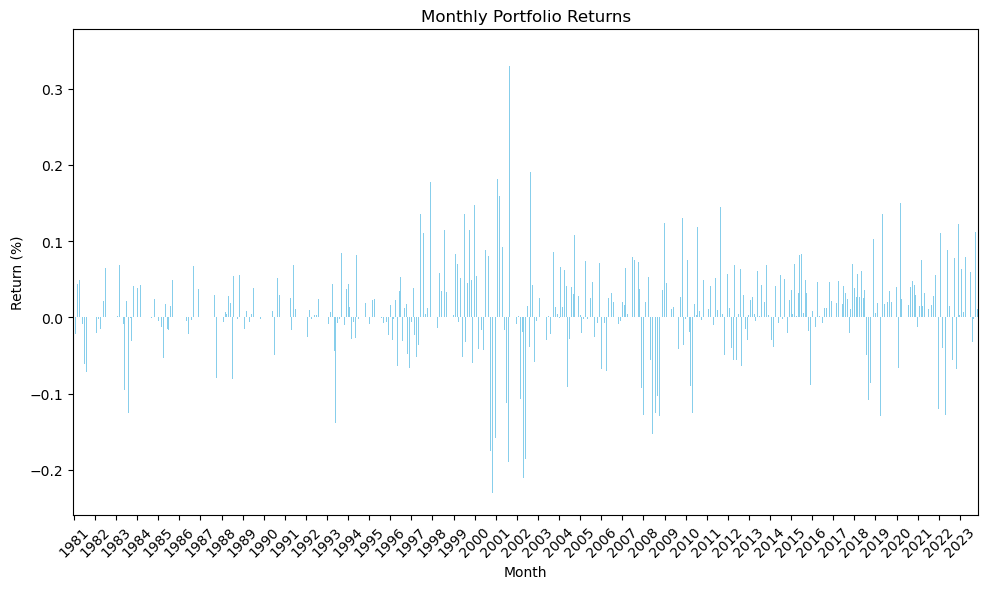

In [11]:

plt.figure(figsize=(10, 6))
ax = monthly_returns.plot(kind='bar', color="skyblue") 
 
plt.title("Monthly Portfolio Returns")
plt.xlabel("Month")
plt.ylabel("Return (%)")
ax.set_xticks(range(0, len(monthly_returns.index), 12))  #change x interval to 12 month
ax.set_xticklabels([date.strftime('%Y') for i, date in enumerate(monthly_returns.index) if i % 12 == 0], rotation=45)

plt.tight_layout()
plt.show()

In [12]:
nvda_data = yf.download('NVDA', start='1999-01-01', end='2023-12-31')
nvda_data['Monthly Return'] = nvda_data['Adj Close'].resample('M').ffill().pct_change() * 100
nvda_monthly_returns = nvda_data['Monthly Return'].dropna()

 
max_return_month = nvda_monthly_returns.idxmax()
max_return_value = nvda_monthly_returns.max()

print(f"Month with the highest return: {max_return_month.strftime('%B %Y')}, Return: {max_return_value:.2f}%")

[*********************100%***********************]  1 of 1 completed

Month with the highest return: February 2000, Return: 72.68%


[*********************100%***********************]  7 of 7 completed


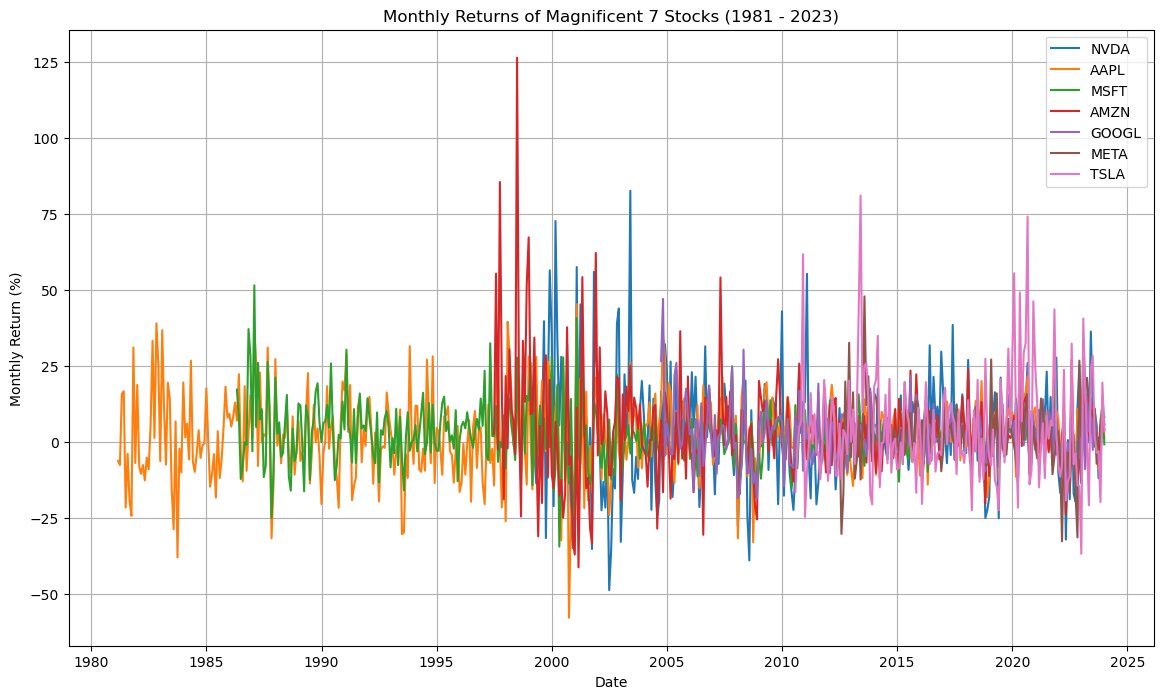

In [13]:
# performance of all 7 
tickers = ['NVDA', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA']
data = yf.download(tickers, start='1981-01-01', end='2023-12-31', group_by='ticker')


monthly_returns = {}


for ticker in tickers:
    ticker_data = data[ticker]['Adj Close'].ffill()  
    monthly_returns[ticker] = ticker_data.resample('M').ffill().pct_change() * 100 
plt.figure(figsize=(14, 8))
for ticker, returns in monthly_returns.items():
    plt.plot(returns.index, returns, label=ticker)

plt.title("Monthly Returns of Magnificent 7 Stocks (1981 - 2023)")
plt.xlabel("Date")
plt.ylabel("Monthly Return (%)")
plt.legend()
plt.grid(True)
plt.show()



# comparisom with S&P

In [14]:

sp500 = yf.download('^GSPC', start=start_date, end=end_date)
sp500['Daily Return'] = sp500['Adj Close'].pct_change().dropna()


portfolio_returns = daily_value_df['Portfolio'].pct_change().dropna()
portfolio_total_return = (daily_value_df['Portfolio'].iloc[-1] / daily_value_df['Portfolio'].iloc[0]) - 1
portfolio_annual_return = (1 + portfolio_total_return) ** (252 / len(portfolio_returns)) - 1
portfolio_annual_volatility = portfolio_returns.std() * np.sqrt(252)

portfolio_cumulative = (1 + portfolio_returns).cumprod()
portfolio_rolling_max = portfolio_cumulative.cummax()
portfolio_drawdown = (portfolio_cumulative - portfolio_rolling_max) / portfolio_rolling_max
portfolio_max_drawdown = portfolio_drawdown.min()


portfolio_sharpe_ratio = (portfolio_annual_return-risk_free_rate) / portfolio_annual_volatility

 #S&P
sp500_total_return = (sp500['Adj Close'][-1] / sp500['Adj Close'][0]) - 1
sp500_annual_return = (1 + sp500_total_return) ** (252 / len(sp500['Daily Return'])) - 1
sp500_annual_volatility = sp500['Daily Return'].std() * np.sqrt(252)


sp500_cumulative = (1 + sp500['Daily Return']).cumprod()
sp500_rolling_max = sp500_cumulative.cummax()
sp500_drawdown = (sp500_cumulative - sp500_rolling_max) / sp500_rolling_max
sp500_max_drawdown = sp500_drawdown.min()


sp500_sharpe_ratio = (sp500_annual_return -risk_free_rate)/ sp500_annual_volatility


comparison = {
    "Metric": ["Total Return (%)", "Annual Return (%)", "Annual Volatility (%)", "Maximum Drawdown (%)", "Sharpe Ratio"],
    "Portfolio": [
        portfolio_total_return * 100,
        portfolio_annual_return * 100,
        portfolio_annual_volatility * 100,
        portfolio_max_drawdown * 100,
        portfolio_sharpe_ratio
    ],
    "S&P 500": [
        sp500_total_return * 100,
        sp500_annual_return * 100,
        sp500_annual_volatility * 100,
        sp500_max_drawdown * 100,
        sp500_sharpe_ratio
    ]
}

# Display the comparison in a DataFrame
comparison_df = pd.DataFrame(comparison)
comparison_df


[*********************100%***********************]  1 of 1 completed


,Metric,Portfolio,S&P 500
0,Total Return (%),4262.657779,3398.481888
1,Annual Return (%),9.175882,8.615281
2,Annual Volatility (%),21.827034,17.969694
3,Maximum Drawdown (%),-56.294235,-56.775388
4,Sharpe Ratio,0.328761,0.368135


[*********************100%***********************]  8 of 8 completed


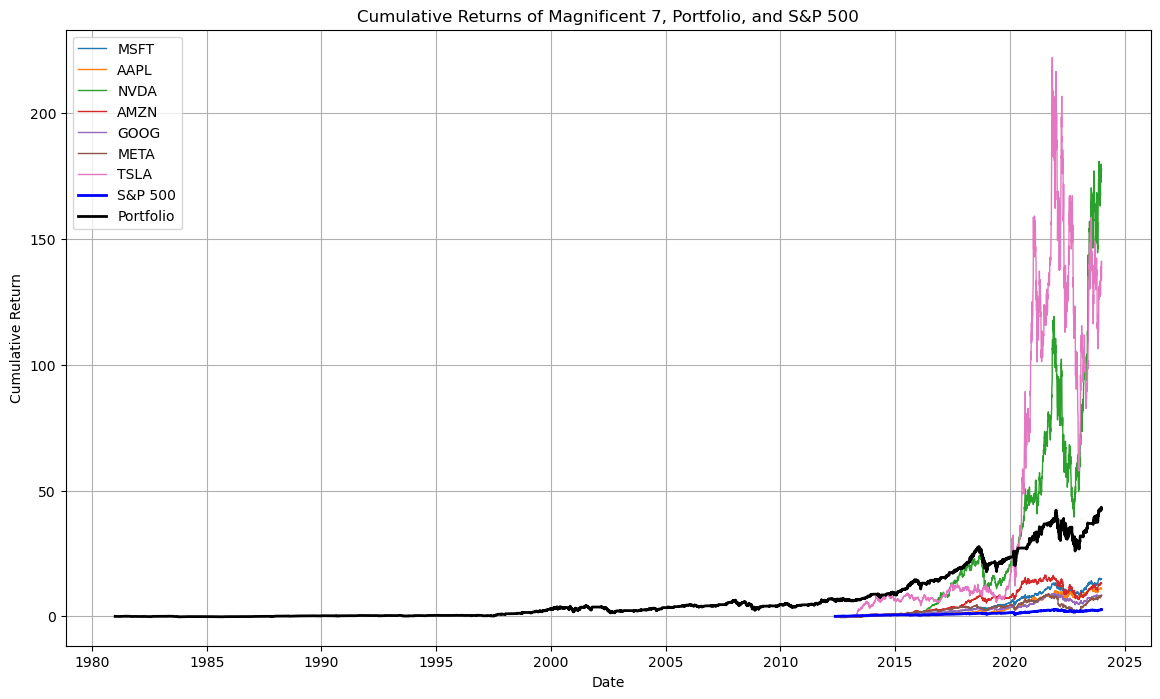

In [15]:
# to display individual performance of stocks, portfolio and s&p

 
 
tickers = ['^GSPC', 'MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

 
daily_returns_ind = data.pct_change().dropna()
cumulative_returns = (1 + daily_returns_ind).cumprod() - 1  #Cumulative returns from the start date

 
plt.figure(figsize=(14, 8))
for ticker in ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker, lw=1)

plt.plot(cumulative_returns.index, cumulative_returns['^GSPC'], label='S&P 500', color='blue', lw=2)
  
portfolio_cumulative_return = (1 + daily_value_df['Portfolio'].pct_change()).cumprod() - 1
plt.plot(portfolio_cumulative_return.index, portfolio_cumulative_return, label='Portfolio', color='black', lw=2)

plt.title("Cumulative Returns of Magnificent 7, Portfolio, and S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()
